Алексей Маляренко

https://drive.google.com/file/d/1CINtBlDtJrfKPtH6s-pA4iMO_BLW69Eq/view?usp=sharing

Ссылка на датасет 166МБ

# ОТЧЁТ

In [6]:
import pandas as pd
import datetime
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode,plot, iplot
import plotly.express as px
import plotly.graph_objects as go
init_notebook_mode(connected = True)
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

## 1 График с событиями по дням и ответ на вопросы: 
## В каком месте маркетинг работает недостаточно хорошо? За счёт чего можно расти?

In [19]:
dfloading = pd.read_csv('SF_case_data.csv') # загрузка файлов 
df = dfloading # копирование
df = df.groupby('date')['event'].count()
df.iplot(title='График с событиями по дням') 
# простой график библиотеки plot.ly 

Тут мы видим точные всплески по праздникам. Значит если дать рекламу прямо за два дня перед ними можно сильно увеличить выручку. А также дать купон на скидку во время праздника, для того чтоб после пика какой-то процент людей совершили больше покупок.

## 2 График с распределением трафика (открытие приложения) по группам «Установили в тот же день» и «Остальные».

In [20]:
def new_c(date1,date2,v): # функция для сравнения 
    if date1 == date2:
        return v
    
df = dfloading # копирование
df['ins_date'] = df['device_id'].map(df[df['event'] == 'app_install'].set_index('device_id')['date'])
df['ins_group'] = df.apply(lambda x: new_c(date1 = x['date'],date2 = x['ins_date'],v = 'Установили в этот же день'),axis=1)
df['ins_group'] = df['ins_group'].fillna('Остальные')
df = df[df['event']=='app_start']
df = df.pivot_table(index='date',columns='ins_group',values='device_id',aggfunc='count')
# длок манипуляций над таблицей

In [21]:
df.iplot(color=['#ffcdd2','#A2D5F2'],mode='lines+markers',title='График с распределением трафика (открытие приложения) по группам')
# Интерактивный график библиотеки plot.ly 

Тут мы видим выделяющейся всплеск во второе воскресение после нового года. Надо обязательно обговорить и распланировать мероприятия по привлечению на каждое первое воскресение после новогодних праздников, там можно привлечь в разы больше новых установок и ROMI резко вырастет (подробнее ниже). Также при выдаче купона на вторую покупку, количество активированных клиентов сильно поднимется.

Вообще любые выходные недалеко от праздников интересны для маркетологов и требуют обсуждений и распределения скидок с купонами.

## 3 График с динамикой установок приложения по каналам привлечения и ответ на вопрос: 
## С каких платных каналов приходит больше и меньше всего пользователей?

In [22]:
df = dfloading # копирование
app_inst_e = df[df['event'] == 'app_install']
app_inst_e = app_inst_e.pivot_table(values='event',index='date',columns='utm_source',aggfunc='count')
first_purchase = df[df['event'] == 'app_install'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')
px.line(app_inst_e).show()
display(first_purchase.T.sort_values('users',axis=1,ascending=False))
# красивая гистограмма

,0,6,2,5,3,1,4
utm_source,-,yandex-direct,google_ads,vk_ads,instagram_ads,facebook_ads,referal
users,32460,29368,26286,23189,20096,13916,9282


В первом квартале Яндекс.Директ принёс нам больше чем другие источники, реферальня программа оказалась самой эффективной из всех по ROMI но привлекла менише всего новых клиентов. 

## 4 Анализ: на каком этапе воронки отваливается большая часть клиентов 
### (отдельно для зарегистрированных и для незарегистрированных пользователей)

## Предложения по оптимизации

In [23]:
df = dfloading # копирование

def new_co(date1,date2,v):
    if str(date1) > str(date2):
        return v
    
register = df[df['event'] == 'register']
df['r_date'] = df['device_id'].map(register.set_index('device_id')['date'])
df['register_group'] = df.apply(lambda x: new_co(date1 = x['date'],date2 = x['r_date'],v = 'Уже зарегистрирован'),axis=1)
df['register_group'] = df['register_group'].fillna('Не регистрировался')

In [24]:
# монолитно собратый блок и з текста и таблиц
display(df[df['event'] == 'app_start']['register_group'].value_counts())
reg = df[df['register_group'] == 'Уже зарегистрирован']
reg = pd.crosstab(reg['utm_source'], reg['event'], values=reg['device_id'], aggfunc='nunique')
reg['1 Поиск'] = reg['search']*100/reg['app_start']
reg['2 Выбор товара'] = reg['choose_item']*100/reg['search']
reg['3 Переход в корзину'] = reg['tap_basket']*100/reg['choose_item']
reg['5 Покупка'] = reg['purchase']*100/reg['tap_basket']
print('Уже зарегистрированные в разрезе источников привлечения')
display(reg)
regn = df[df['register_group'] == 'Не регистрировался']
regn = pd.crosstab(regn['utm_source'], regn['event'], values=regn['device_id'], aggfunc='nunique')
regn['1 Поиск'] = regn['search']*100/regn['app_start']
regn['2 Выбор товара'] = regn['choose_item']*100/regn['search']
regn['3 Переход в корзину'] = regn['tap_basket']*100/regn['choose_item']
regn['4 Регистрация'] = regn['register']*100/regn['tap_basket']
regn['5 Покупка'] = regn['purchase']*100/regn['register']
print('Не зарегистрированные в разрезе источников привлечения')
display(regn)
reg = df[df['register_group'] == 'Уже зарегистрирован']
reg = pd.crosstab(reg['register_group'], reg['event'], values=reg['device_id'], aggfunc='nunique')
reg['1 Поиск'] = reg['search']*100/reg['app_start']
reg['2 Выбор товара'] = reg['choose_item']*100/reg['search']
reg['3 Переход в корзину'] = reg['tap_basket']*100/reg['choose_item']
reg['5 Покупка'] = reg['purchase']*100/reg['tap_basket']
print('Уже зарегистрированные в простом только по шагам варианте')
display(reg)
regn = df[df['register_group'] == 'Не регистрировался']
regn = pd.crosstab(regn['register_group'], regn['event'], values=regn['device_id'], aggfunc='nunique')
regn['1 Поиск'] = regn['search']*100/regn['app_start']
regn['2 Выбор товара'] = regn['choose_item']*100/regn['search']
regn['3 Переход в корзину'] = regn['tap_basket']*100/regn['choose_item']
regn['4 Регистрация'] = regn['register']*100/regn['tap_basket']
regn['5 Покупка'] = regn['purchase']*100/regn['register']
print('Не зарегистрированные, только по шагам ')
display(regn)

Уже зарегистрирован    441486
Не регистрировался     307219
Name: register_group, dtype: int64

Уже зарегистрированные в разрезе источников привлечения


event,app_start,choose_item,purchase,search,tap_basket,1 Поиск,2 Выбор товара,3 Переход в корзину,5 Покупка
utm_source,,,,,,,,,
-,9482,8728,5492,9355,7850,98.660620,93.297702,89.940422,69.961783
facebook_ads,5606,5154,3333,5527,4694,98.590796,93.251312,91.074893,71.005539
google_ads,5399,4948,3121,5335,4438,98.814595,92.746017,89.692805,70.324470
instagram_ads,5686,5288,3548,5618,4842,98.804080,94.126023,91.565809,73.275506
referal,3647,3417,2382,3610,3155,98.985468,94.653740,92.332455,75.499208
vk_ads,6011,5636,3950,5958,5196,99.118283,94.595502,92.193045,76.020015
yandex-direct,5396,4928,3099,5304,4464,98.295033,92.911011,90.584416,69.422043


Не зарегистрированные в разрезе источников привлечения


event,app_install,app_start,choose_item,purchase,register,search,tap_basket,1 Поиск,2 Выбор товара,3 Переход в корзину,4 Регистрация,5 Покупка
utm_source,,,,,,,,,,,,
-,32460,48670,38026,14073,16527,46742,29223,96.038627,81.352959,76.850050,56.554769,85.151570
facebook_ads,13916,23780,18713,7506,8672,22822,14592,95.971405,81.995443,77.977876,59.429825,86.554428
google_ads,26286,35778,27416,9777,11405,34217,20765,95.636984,80.123915,75.740444,54.924151,85.725559
instagram_ads,20096,29237,22858,9394,10750,28017,17881,95.827205,81.586180,78.226442,60.119680,87.386047
referal,9282,14866,11880,5503,6193,14316,9518,96.300283,82.984074,80.117845,65.066190,88.858389
vk_ads,23189,32353,25422,10919,12421,31010,20014,95.848917,81.980006,78.727087,62.061557,87.907576
yandex-direct,29368,38578,29591,10581,12342,36933,22417,95.735912,80.120759,75.756142,55.056430,85.731648


Уже зарегистрированные в простом только по шагам варианте


event,app_start,choose_item,purchase,search,tap_basket,1 Поиск,2 Выбор товара,3 Переход в корзину,5 Покупка
register_group,,,,,,,,,
Уже зарегистрирован,40991,37926,24880,40482,34517,98.758264,93.686083,91.011443,72.080424


Не зарегистрированные, только по шагам 


event,app_install,app_start,choose_item,purchase,register,search,tap_basket,1 Поиск,2 Выбор товара,3 Переход в корзину,4 Регистрация,5 Покупка
register_group,,,,,,,,,,,,
Не регистрировался,154597,190884,155691,67753,78310,184488,125414,96.649274,84.390855,80.553147,62.441195,86.518963


Для уже зарегистрированных пользователей, провал который существенно влияет на конверсию, это покупка после перехода в корзину, что просто требует комплекс мер по реактивации брошенных корзин пользователя.

А с не зарегистрированными всё сложнее, ведь без регистрации нельзя купить товар, и решить этот вопрос можно только максимальным упрощением формы регистрации, или более органичного её вплетение в покупку. В идеале так чтоб пользователь сначала купил, а уже для получения зарегистрировался.

## 5 Выбор лучшего и худшего каналов по конверсии в первую покупку.

In [25]:
df = dfloading # копирование
f_opens = df[df['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')
f_purchase = df[df['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')
cp_merge = f_opens.merge(f_purchase, how = 'left', on = 'utm_source')
cp_merge.columns = ['utm_source', 'f_opens','f_purchase']
cp_merge['CR_в_первую_покупку'] = cp_merge['f_purchase']/cp_merge['f_opens']
cp_merge.sort_values('CR_в_первую_покупку',ascending=False)

,utm_source,f_opens,f_purchase,CR_в_первую_покупку
4,referal,11983,5803,0.484269
1,facebook_ads,18844,7903,0.419391
5,vk_ads,27905,11460,0.410679
3,instagram_ads,24818,9820,0.395681
0,-,41456,14786,0.356667
2,google_ads,31437,10167,0.323409
6,yandex-direct,34441,10936,0.317529


Лучший здесь оказалась Реферальная программа, видимо денежная мотивация сильно помогла и люди почти с 50% процентным шансом покупают через этот источник. Далее идёт на одной строчке две классические соц сети Фейсбук и Вконтакте, следует присмотреться к ним.

Яндекс директ стал самым плохим каналом.

## 6 Расчёт ROMI для всех каналов.

In [26]:
df = dfloading # копирование
referal_cost = len(df[(df['event'] == 'purchase')&(df['utm_source'] == 'referal')].sort_values('date').drop_duplicates('device_id'))*100*2
# важно утчнить что тут два фильтра
advertising_costs = {'utm_source':['yandex-direct','google_ads','facebook_ads','instagram_ads','vk_ads','referal','-'], # таблица с маркетинговыми расходами
       'advertising_costs':[10491707,10534878,8590498,8561626,9553531,referal_cost,1]} 
advertising_costs_purchase = df[df['purchase_sum'].notna()].groupby(by='utm_source')['purchase_sum'].sum().reset_index()
advertising_costs_purchase = advertising_costs_purchase.merge(pd.DataFrame(advertising_costs), left_on='utm_source', right_on='utm_source')
def new_col(date1,date2):
    return (date1-date2)/date2
advertising_costs_purchase['ROMI'] = advertising_costs_purchase.apply(lambda x: new_col(date1 = x['purchase_sum'],date2 = x['advertising_costs']),axis=1)
advertising_costs_purchase['ROMI'] = advertising_costs_purchase['ROMI'].map(lambda x:x*100)
advertising_costs_purchase['ROMI'] = advertising_costs_purchase['ROMI'].map('{:,.2f}%'.format)
advertising_costs_purchase['ROMI'][0]='-'
advertising_costs_purchase['advertising_costs'][0]='-'

In [27]:
advertising_costs_purchase.sort_values('purchase_sum',ascending=False)

,utm_source,purchase_sum,advertising_costs,ROMI
0,-,21449749.5,-,-
5,vk_ads,16389652.5,9553531,71.56%
3,instagram_ads,14546969.0,8561626,69.91%
6,yandex-direct,13915368.0,10491707,32.63%
2,google_ads,12868276.0,10534878,22.15%
1,facebook_ads,12249901.0,8590498,42.60%
4,referal,8837044.5,1272400,594.52%


Если отсортировать по прибыли, то в самом низу будет Реферальная программа, но при этом у неё просто невероятные показатели, надо увеличивать бюджет этого источника. Из-за его недооцененности компания недополучает прибыль.

## 7 Таблица когорт (в абс. и %) по неделе первого посещения, выбор самой большой и самой активной когорт.

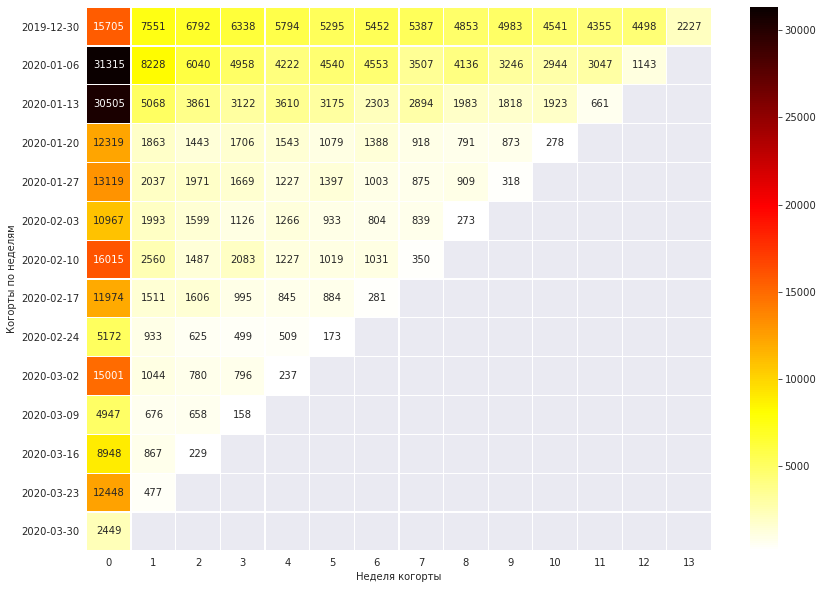

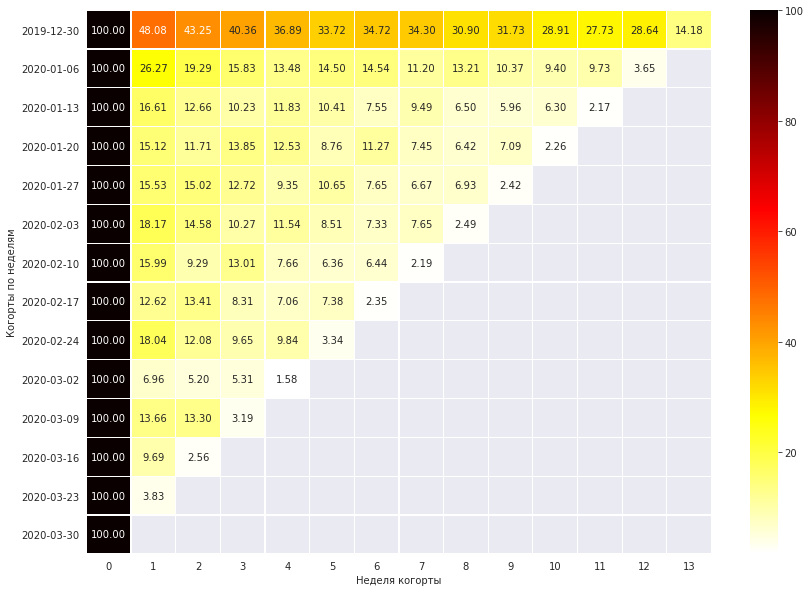

In [28]:
df = dfloading # копирование
entrances = df[df['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id')
df['f_entrance'] = df['device_id'].map(entrances.set_index('device_id')['date'])
df['f_entrance'] = pd.to_datetime(df['f_entrance'], format = '%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['f_entrance_cohort'] = df['f_entrance'].apply(lambda x: x + datetime.timedelta(days=-x.weekday()))
df['n_week'] = df['date'] - df['f_entrance_cohort']
df['n_week'] = df['n_week'].apply(lambda x: x.days // 7 )
df['f_entrance_cohort'] = df['f_entrance_cohort'].apply(lambda x: str(x)[:10])

piwot = pd.pivot_table(df, index = 'f_entrance_cohort',columns = 'n_week',values ='device_id',aggfunc = 'nunique')
with sns.axes_style("dark"): # официальный способ сменить подложку графика
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(piwot, annot=True, fmt=".0f", cmap="hot_r",linewidths=.2);
    plt.ylabel('Когорты по неделям')
    plt.xlabel('Неделя когорты')
    
piwot = piwot.apply(lambda x: x*100/piwot[0])
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(piwot, annot=True, fmt=".2f", cmap="hot_r",linewidths=.2); # linewidths=.5
    plt.ylabel('Когорты по неделям')
    plt.xlabel('Неделя когорты')

2019-12-30 Была самая активная когорта.
2020-01-06 Самая многочисленная.

## 8 Таблица когорт (в абс. и %) по неделе первой покупки, выбор самой активной когорты и анализ динамики активности.

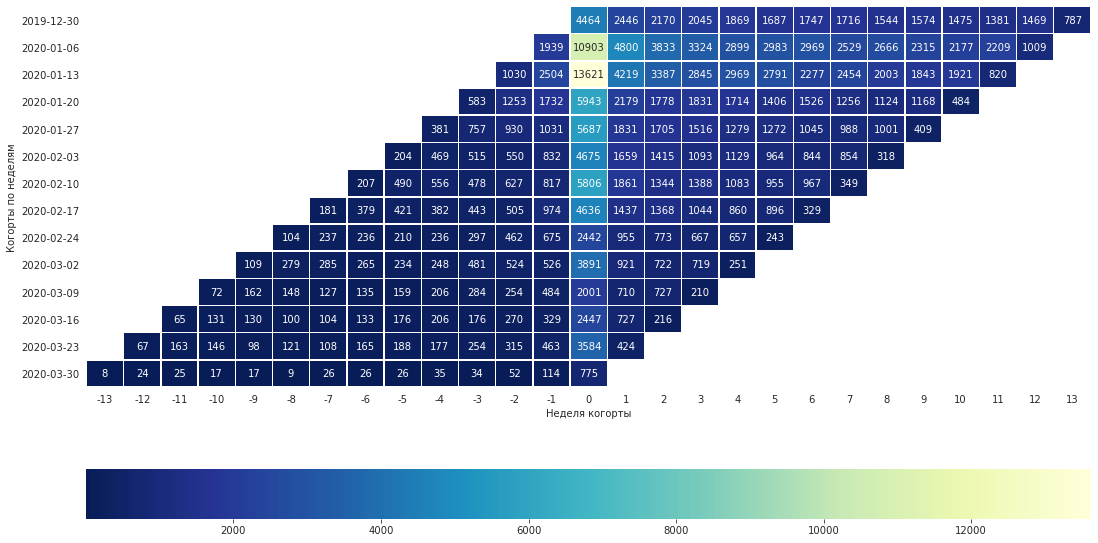

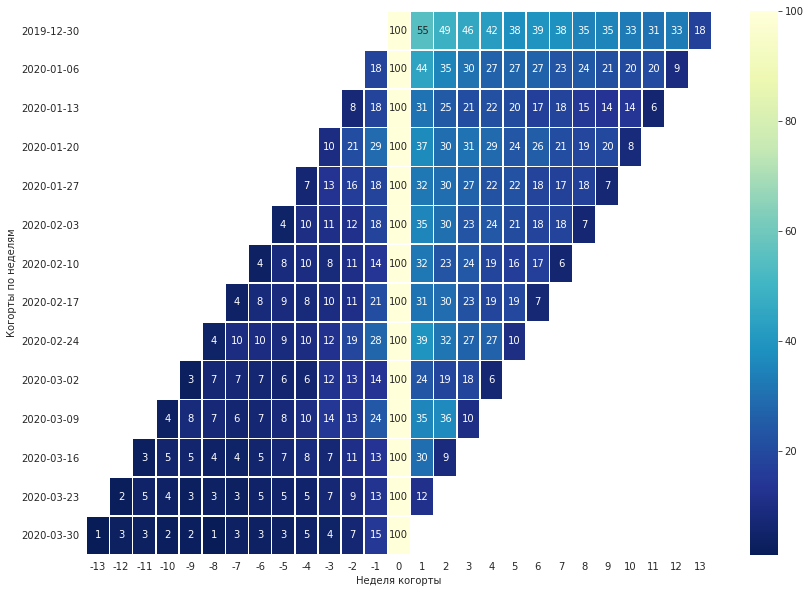

In [29]:
df = dfloading # копирование
purchases = df[df['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id')
df['f_purchase'] = df['device_id'].map(purchases.set_index('device_id')['date'])
df['f_purchase'] = pd.to_datetime(df['f_purchase'], format = '%Y-%m-%d')
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df = df[-df['f_purchase'].isna()]
df['f_purchase_cohort'] = df['f_purchase'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
df['n_week'] = df['date'] - df['f_purchase_cohort']
df['n_week'] = df['n_week'].apply(lambda x: x.days // 7 )
df['f_purchase_cohort'] = df['f_purchase_cohort'].apply(lambda x: str(x)[:10])
viz = df.pivot_table(index='f_purchase_cohort', columns='n_week', values='device_id', aggfunc='nunique')

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu_r",linewidths=.5,cbar_kws={"orientation": "horizontal"}); # интересно развёрнутая полоска градиента
    plt.ylabel('Когорты по неделям')
    plt.xlabel('Неделя когорты')

viz = viz.apply(lambda x: x*100/viz[0])
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu_r",linewidths=.5);
    plt.ylabel('Когорты по неделям')
    plt.xlabel('Неделя когорты')

2019-12-30 и тут оказалась самой активной.

Люди пришедшее в когорте после нового года показали самую лучшую активность, и такие же всплески происходят в когортах на которые выпадают праздничные дни и продолжаются  1-3 недели.

## 9 Расчёт медианного/среднего чека по когортам (недели первой покупки) в каждую неделю с момента первой покупки.

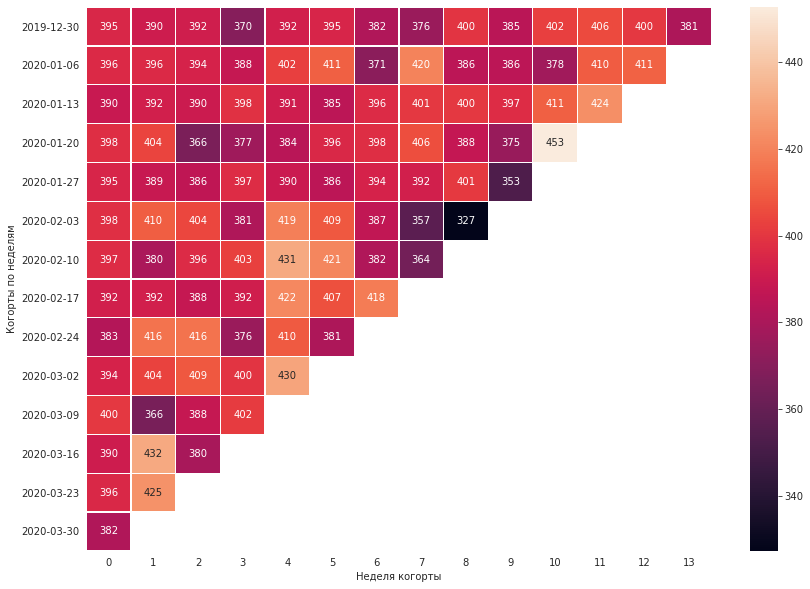

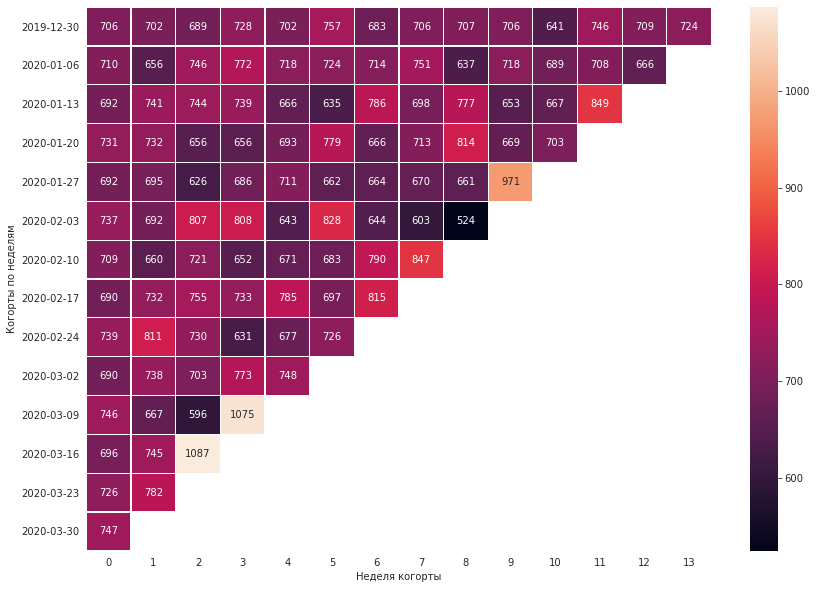

In [30]:
viz = df.pivot_table(index='f_purchase_cohort', columns='n_week', values='purchase_sum', aggfunc='median')

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f",linewidths=.2);
    plt.ylabel('Когорты по неделям')
    plt.xlabel('Неделя когорты')
viz = df.pivot_table(index='f_purchase_cohort', columns='n_week', values='purchase_sum', aggfunc='mean')

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f",linewidths=.2);
    plt.ylabel('Когорты по неделям')
    plt.xlabel('Неделя когорты')   

Медианный и средний чек отличаются на порядочное количество условных единиц, что вызывает вопросы и надобность дополнительно поделить на страты датасет и найти те группы покупателей, что скупаются на больше суммы, для дальнейшего исследования конкретно их чека.